In [58]:
#! pip install regionmask;
#! pip install cartopy;
#import regionmask
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import datetime as dt

import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb



reduce grid bbox:  [-2584859.0247218814, 2714189.166638696, -2151842.919231681, 3139273.504268901]


TypeError: 'NoneType' object is not iterable

In [77]:
msk
#fig, ax = grid.plot(msk[0], cmap='viridis', add_landmask=False)
#ax.coastlines(resolution='50m')


[masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, 3.0, 3.0, ..., 20.0, --, --],
         ...,
         [--, 20.0, 20.0, ..., 9.564607416141998, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True, False, False, ..., False,  True,  True],
         ...,
         [ True, False, False, ..., False,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=1e+20)]

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                   (nv: 2, time: 56, x: 782, y: 651)
Coordinates:
  * time                      (time) datetime64[ns] 2013-02-01T06:00:00 ... 2...
Dimensions without coordinates: nv, x, y
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    longitude                 (y, x) float32 ...
    latitude                  (y, x) float32 ...
    siu                       (time, y, x) float32 ...
    siv                       (time, y, x) float32 ...
    sic                       (time, y, x) float32 ...
    sit                       (time, y, x) float32 ...
    snt                       (time, y, x) float32 ...
    fyi_fraction              (time, y, x) float32 ...
    sit_thin                  (time, y, x) float32 ...
    hfos                      (time, y, x) float32 ...
    hfs                       (time, y, x) float32 ...
    sia                       (time, y, x) float32 ...
    sfo             

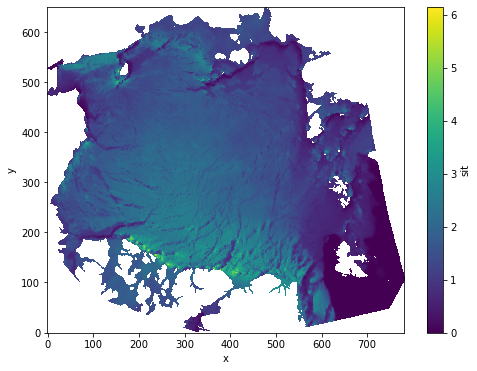

In [62]:
# load nextsim data (moorings)

data=xr.open_dataset('/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/4/Moorings_2013m02.nc')
#data = data.set_coords(['longitude', 'latitude']) # same as for nextsim data
#data=data.rename({'longitude':'lon', 'latitude':'lat'})

sit = data['sit'].sel(time='2013-02-22').mean(axis=0)
print(data)
     
nlon = data.longitude.values
nlat = data.latitude.values



print('Grid dims: ', nlon.min(), nlon.max(), nlat.min(), nlat.max()) 

# tetst PLOT
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
sit.plot.imshow(ax=ax)


In [53]:
# get NSIDC region mask 
import pyproj

sio_mask = xr.open_dataset('/cluster/home/rheinlender/data/NSIDC/sio_mask.nc')
lons = sio_mask.lon
lats = sio_mask.lat
print("Grid extent:    ", lons.values.min(), lons.values.max(), lats.values.min(), lats.values.max())
print(sio_mask)

# change names of dimensions for mask and make lat and lon coordinates
#sio_mask = sio_mask.rename({'nx':'lon', 'ny':'lat'}) # same as for nextsim data
#sio_mask = sio_mask.set_coords(['lon', 'lat']) 
sio_mask = sio_mask.rename({'nx':'x', 'ny':'y'}).set_coords(['lon', 'lat']) # same as for nextsim data

# change order of dimensions
sio_mask=sio_mask.transpose()
sio_mask

Grid extent:     -180.0 179.81398 31.10267 89.83682
<xarray.Dataset>
Dimensions:       (nregions: 21, nx: 304, ny: 448)
Dimensions without coordinates: nregions, nx, ny
Data variables:
    mask          (nx, ny) int32 ...
    lat           (nx, ny) float32 31.10267 31.25011 ... 34.6212 34.47208
    lon           (nx, ny) float32 168.32042 168.4334 ... -9.87249 -9.99898
    area          (nx, ny) float32 ...
    region_names  (nregions) |S17 ...


ValueError: IndexVariable objects must be 1-dimensional

ValueError: IndexVariable objects must be 1-dimensional

<xarray.DataArray 'lat' ()>
array(61.3491, dtype=float32) <xarray.DataArray 'lat' ()>
array(89.83682, dtype=float32)


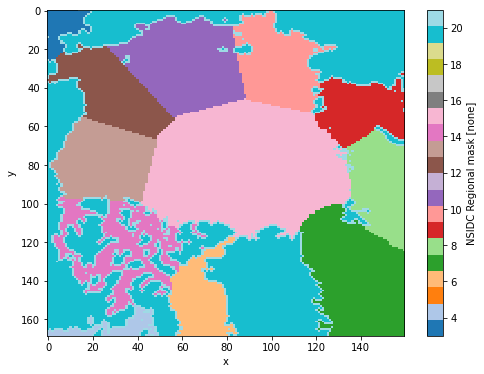

In [47]:
# get mask

# pick domain that roughly matches nextsim domain
basin_mask =sio_mask.sel(x=slice(60, 220), y=slice(150, 320))

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
basin_mask['mask'][:-1].plot.imshow(ax=ax,vmax=21, origin='upper', cmap='tab20')

print(mask2.lat.min(), mask2.lat.max())



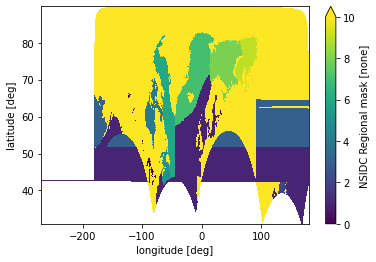

In [65]:
# Interpolate basin_mask on the nextsim thickness variable

basin_mask_interp = sio_mask.mask.interp_like(data.sit, method='nearest')
basin_mask_interp.plot(vmax=10)



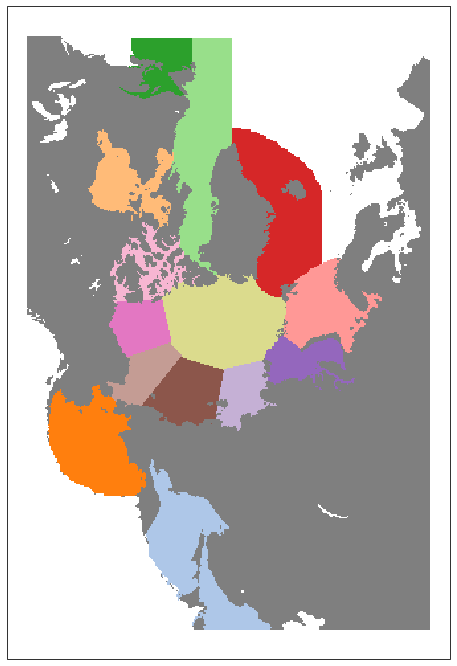

In [9]:
# Plot regions

minlat =  lats.min()
maxlat = lats.max()
extent= [-180, 179.81398, minlat, 90]

# NSIDC projection information
#proj4 = pyproj.Proj(proj=stereo, lat_0=90,lat_ts=70, lon_0=-45, k=1, x_0=0,y_0=0, a=6378273, b=6356889.449, units=m).srs

proj=ccrs.NorthPolarStereo(central_longitude=0)
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection=proj)

region_names =      {0: 'Ice-free Oceans  ', 
                    1: 'Sea of Okhotsk   ', 
                    2: 'Bering           ',
                    3: 'Hudson Bay       ', 
                    4: 'St John          ', 
                    5: 'Baffin Bay       ',
                    6: 'East Greeland Sea', 
                    7: 'Barents Sea      ',
                    8: 'Kara Sea         ',
                    9: 'Laptev Sea       ',
                    10: 'East Siberian Sea', 
                    11: 'Chukchi Sea      ',
                    12: 'Beaufort Sea     ',
                    13: 'Canadian Islands ', 
                    14: 'Central Arctic   ',
                    20: 'land             ',
                   }

cmap = plt.cm.tab20  # define the colormap
col_dict= {         0: 'white', 
                    1: cmap.colors[1], 
                    2: cmap.colors[2],
                    3: cmap.colors[3], 
                    4: cmap.colors[4], 
                    5: cmap.colors[5],
                    6: cmap.colors[6], 
                    7: cmap.colors[7],
                    8: cmap.colors[8],
                    9: cmap.colors[9],
                    10: cmap.colors[10], 
                    11: cmap.colors[11],
                    12: cmap.colors[12],
                    13: cmap.colors[13], 
                    14: cmap.colors[17],
                    20: cmap.colors[14],
                   }

# We create a colormar from our list of colors
cm = mpl.colors.ListedColormap([col_dict[x] for x in col_dict.keys()])

## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 15, 16 + 1.0)
#norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)


## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, cm.N, clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

cs = ax.pcolormesh(basin_mask.transpose(), norm=norm, transform=ccrs.NorthPolarStereo(),cmap=cm)


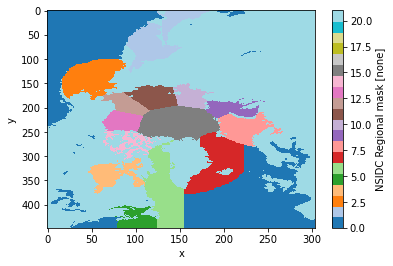

In [67]:
basin_mask.transpose().plot.imshow(vmax=21, origin='upper', cmap='tab20')

In [ ]:
## Define regions for calculating distributions

REGION={0: "Beafort",
       1: "Chukchi",
       2: "East Siberia",
       3: "Laptev",
       4: "Kara",
       5: "Central Arctic",
       6: "Arctic total",
      }


# regions can be selected by number, abbreviation or long name
regions = [0, "Arctic Ocean", "Arctic Ocean"]

# create regions
Beaufort = np.array([[-110.0, 67], [-160, 67], [-160, 77.8], [-110, 77.8]])
Chukchi = np.array([[-160.0, 65.8], [-180, 65.8], [-180, 77.8], [-160, 77.8]])
Arctic_central = np.array([[-180.0, 77.8], [180, 77.8], [180, 90], [-180, 90]])

names = ["Beaufort Sea", "Chukchi Sea", "Central Arctic"]
abbrevs = ["Beaufort Sea", "Chukchi Sea", "Central Arctic"]
# Add regions to regionsmask
ArcticRegions = regionmask.Regions([Beaufort, Chukchi, Arctic_central], names=names, abbrevs=abbrevs, name="Arctic")

# regions to plot
regions=[0,1,2] 

proj = ccrs.NorthPolarStereo(central_longitude=0)

# do the plot
plt.close('all')
fig = plt.figure(figsize=(12,12))
ax = ArcticRegions.plot(regions=regions, add_ocean=False, resolution="50m", proj=proj, label="abbrev")



In [ ]:
# compare distribution before/after break-up event